In [ ]:
import pandas as pd
import findspark
from pyspark.sql import SparkSession
from pyspark import SparkConf

# for dataframe and udf
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *


from pyspark.sql.functions import col
from pyspark.sql import functions as F

from igraph import Graph
from pyspark.sql.window import Window
from pyspark.sql.functions import col

from functools import reduce
from pyspark.sql.functions import collect_set, min as min_, expr,array_min,max
from pyspark.sql.functions import lit

from pyspark.sql.types import StringType, IntegerType, LongType, FloatType, ArrayType,StructType,StructField, BooleanType

import pandas as pd
import glob

import time

import matplotlib.pyplot as plt

from pyspark.sql.types import BooleanType


In [ ]:
import os
os.environ["SPARK_HOME"] =  "/root/anaconda3/lib/python3.9/site-packages/pyspark" 
os.environ["JAVA_HOME"] ="/usr"

# Lancer spark

In [ ]:
findspark.init() 

def demarrer_spark(NB_CORES):
  local = f"local[{NB_CORES}]"
  # le parametre spark.local.dir indique le repertoire contenant les données temporaires ecrites sur disque lorsque le shufle ne tient pas en memoire
  appName = "PLDAC"
  configLocale = SparkConf().setAppName(appName).setMaster(local).\
  set("spark.executor.memory", "320G").\
  set("spark.driver.memory","320G").\
  set("spark.sql.catalogImplementation","in-memory").\
  set("spark.driver.maxResultSize", "20G").\
  set("spark.local.dir", "/data/bd/spark/tmp").\
  set("spark.sql.execution.arrow.pyspark.enabled", "true")
    

# # to allow sharing in memory arow format between pandas and spark : speeds up the creation of a spark df from a pandas df
# spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")


  spark = SparkSession.builder.config(conf = configLocale).getOrCreate()
  sc = spark.sparkContext
  sc.setLogLevel("ERROR")
  
  # spark.conf.set("spark.sql.autoBroadcastJoinThreshold","-1")
    
  # On ajuste l'environnement d'exécution des requêtes à la taille du cluster (NB_CORES coeurs)
  shuffle_partitions = 3 * NB_CORES
  print("shuffle", shuffle_partitions)
  spark.conf.set("spark.sql.shuffle.partitions", str(shuffle_partitions))    

  print("session démarrée, son id est ", sc.applicationId)
  return spark


# Comparaison du temps de lecture des fichiers avec plusieurs degrés de parallélisme :

In [ ]:
import time
def read_files(partition_folder,nb_partition ):
   
    def read_file(partition_file) :
        #print(partition_file)
        try:
            df = pd.read_parquet(partition_file)
            return True
        except Exception as e:
            return False

    # Schéma du DataFrame
    schema = StructType([
        StructField("file", StringType(), False)
    ])
    
    # Données à partir desquelles créer le DataFrame
    data = [(i,) for i, file in enumerate(os.listdir(partition_folder))]

    # Création du DataFrame
    df = spark.createDataFrame(data, schema).repartition(nb_partition)
    # Enregistrer la fonction UDF
    read_file_udf = F.udf(read_file,  BooleanType())
    read_files_df = df.withColumn(
        "read_bool",
        read_file_udf(
            F.concat(
                F.lit(partition_folder + "/partition_"), 
                df["file"] , 
                F.lit(".parquet")
            )
        )
    )
    
    return read_files_df

In [ ]:
spark = demarrer_spark(60)
partition_folder = f"/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions"

shuffle 180
session démarrée, son id est  local-1712392800788


In [ ]:
read_files_df = read_files(partition_folder , 60)

In [ ]:
import time 
file_path = f"/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/read_files_df"
start_time = time.time()
read_files_df.write.mode("overwrite").parquet(file_path)
print(time.time() - start_time)

11.047338008880615


In [ ]:

import numpy as np
degree_parallelisme = range(1,60,10)
times_moy = []
for d in degree_parallelisme:
    times=[]
    for i in range(15):
        read_files_df = read_files(partition_folder , d)
        start_time = time.time()
        read_files_df.write.mode("overwrite").parquet(file_path)
        times.append(time.time() - start_time)
    times_moy.append(np.mean(times))
    
    

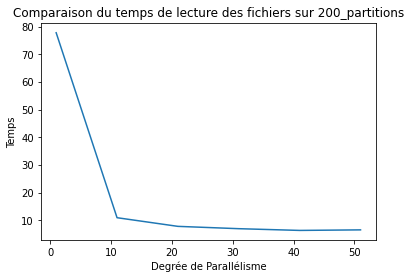

In [ ]:
plt.plot(degree_parallelisme, times_moy)

plt.xlabel('Degrée de Parallélisme')
plt.ylabel('Temps')
plt.title('Comparaison du temps de lecture des fichiers sur 200_partitions') 

plt.show()

#clculer la moyenne avec le write

In [ ]:
spark.stop()

# Comparaison du temps de calcul des composantes partielles :

In [ ]:
def calculate_partition_components(partition_folder , nb_partition):
   
    def components(partition_file, num_file , d) :
        df = pd.read_parquet(partition_file )
        g = Graph.TupleList(df[['query_id', 'target_id']].itertuples(index=False), directed=False)
        connected_components = g.connected_components()
        node_ids=[]
        for component in connected_components:
            node_ids.append([g.vs[node_index]['name'] for node_index in component])
        #on trie en fonction de la taille 
        composantes_triees = sorted(node_ids, key=len, reverse=True)
        # Créer une liste de lignes pour chaque composante
        rows = []
        for i, component in enumerate(composantes_triees):
            for seqid in component:
                rows.append((seqid , i)) 
        return rows

    # Schéma du DataFrame
    schema = StructType([
        StructField("file", StringType(), False)
    ])
    
    # Données à partir desquelles créer le DataFrame
    data = [(i,) for i in range(200)]

    # Création du DataFrame
    df = spark.createDataFrame(data, schema).repartition(nb_partition)
    # Enregistrer la fonction UDF
    schema_components = StructType([
        StructField("seqID", StringType(), nullable=False),
        StructField("component_id", IntegerType(), nullable=False)
    ])
    components_udf = F.udf(components, ArrayType(schema_components))
    #df_with_components = df.withColumn("components", components_udf(F.concat(F.lit(partition_folder+"/"), df["file"])))
    df_with_components = df.withColumn(
        "components",
        components_udf(
            F.concat(
                F.lit(partition_folder + "/partition_"), 
                df["file"] , 
                F.lit(".parquet")
            ) , 
            df["file"],
            F.lit(nb_partition)
        )
    )
    
    return df_with_components

In [ ]:
spark = demarrer_spark(60)

shuffle 180
session démarrée, son id est  local-1712401023419


In [ ]:
partition_folder = f"/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions"

In [ ]:
df_with_component = calculate_partition_components(partition_folder , 60)

In [ ]:
start_time = time.time()
directory_path =f"/data/bd/dataset/proteine/80_80/G99/graph_partitionned_components/200_partitions_components"
# df_with_component.write.mode("overwrite").parquet(directory_path)
df_with_component.write.mode("overwrite").parquet(directory_path)
print(time.time() - start_time)


60.28257203102112


In [ ]:
df_with_component = calculate_partition_components(partition_folder , 8)
start_time = time.time()
df_with_component.write.mode("overwrite").parquet(directory_path)
print(time.time() - start_time)


317.6276843547821


In [ ]:
df_with_component = calculate_partition_components(partition_folder , 20)
start_time = time.time()
df_with_component.write.mode("overwrite").parquet(directory_path)
print(time.time() - start_time)


77.11013054847717


In [ ]:
df_with_component = calculate_partition_components(partition_folder , 60)
start_time = time.time()
df_with_component.write.mode("overwrite").parquet(directory_path)
print(time.time() - start_time)


56.03961229324341


In [ ]:

degree_parallelisme = range(1,60,10)
times_moy = []

for d in degree_parallelisme:
    times=[]
    for i in range(5):
        df_with_component = calculate_partition_components(partition_folder , d)
        start_time = time.time()
        df_with_component.write.mode("overwrite").parquet(directory_path)
        times.append(time.time() - start_time)
    times_moy.append(np.mean(times))
    
    

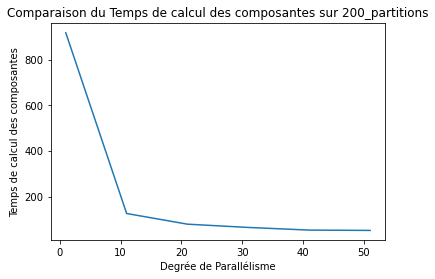

In [ ]:
plt.plot(degree_parallelisme, times)

plt.xlabel('Degrée de Parallélisme')
plt.ylabel('Temps de calcul des composantes')
plt.title('Comparaison du Temps de calcul des composantes sur 200_partitions') 

plt.show()



## G prime : 

In [ ]:
def components_2(edges):
    # Créer un graphe à partir des arêtes
    g = Graph.TupleList(edges, directed=False)
    
    connected_components = g.connected_components()
    node_ids=[]
    for component in connected_components:
        node_ids.append([g.vs[node_index]['name'] for node_index in component])
    #on trie en fonction de la taille 
    composantes_triees = sorted(node_ids, key=len, reverse=True)
    # Créer une liste de lignes pour chaque composante
    rows = []
    for i, component in enumerate(composantes_triees):
        for seqid in component:
            rows.append(Row(partial_component=seqid ,component=i ))
    
    # Créer un DataFrame Spark à partir de la liste de lignes
    result_df = spark.createDataFrame(rows)
    return result_df

In [ ]:
def calculate_components(folder_partition,d ):
    # Claclul des composantes partielles dans chaque partition
    df_with_components = calculate_partition_components(folder_partition,d)
    
    df_exploded = df_with_components.select('file',  F.explode('components').alias('component'))
    df_split = df_exploded.select("file", col("component.seqID").alias("seqID"), col("component.component_id").alias("component_id"))
    
    # Ajouter une colonne d'identifiant unique basée sur le couple (file, component_id)
    windowSpec = Window.orderBy("file", "component_id")
    df = df_split.withColumn("new_component_id", dense_rank().over(windowSpec))
    new_df = df.select("seqID","new_component_id")

    # new_df = df_split.select(
    #             'seqID',
    #             concat(col('file'), lit(':'), col('component_id')).alias('new_component_id')
    #         )
    
    #cration d'un graph ou chaque noeud est le numero d'une composante (new_graph)

    components_per_node = new_df \
        .groupby("seqID") \
        .agg(collect_set("new_component_id").alias("components")) \
        .withColumn("min_component", array_min("components"))

    # components_per_node = new_df \
    #     .groupby("seqID") \
    #     .agg(collect_set("new_component_id").alias("components")) \
    #     .withColumn("min_component", array_min("components"))


    components_per_node_exploded = components_per_node.select('seqID', 'min_component', F.explode('components').alias('component'))
    result = components_per_node_exploded.where(col("component") > col("min_component")).drop("seqID").dropDuplicates()
  
    
    new_graph = result.withColumnRenamed("min_component", "src").withColumnRenamed("component", "dst")

    #calcul des composantes sur le nouveau graph
    edges =new_graph.select('src', 'dst').collect()
    composantes_df = components_2(edges)

    composantes_df_exploded = composantes_df \
            .groupby("component") \
            .agg(collect_set("partial_component").alias("partial_components")) \
            .withColumn("min_partial_component", array_min("partial_components")) \
            .selectExpr("explode(partial_components) as partial_component" , "min_partial_component")
    
    #resultat final en faisant une jointure gauche
    result = components_per_node.join(composantes_df_exploded, components_per_node.min_component == composantes_df_exploded.partial_component, "left_outer") \
               .select(components_per_node.seqID, when(composantes_df_exploded.partial_component.isNull(), components_per_node.min_component).otherwise(composantes_df_exploded.min_partial_component).alias("new_component_id"))


    #ecriture du résultat dans des fichier parquet
    file_path = f"/data/bd/dataset/proteine/80_80/G99/graph_nodeID_only"
    result.repartition(1).write.mode("overwrite").parquet(file_path)
    
    return result

In [ ]:
def calculate_components_bis(folder_partition,d ):    
    # partition_folder = f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/200_partitions/"
    df_with_components = calculate_partition_components(folder_partition,d)

    df_exploded = df_with_components.select('file',  F.explode('components').alias('component'))
    df_split = df_exploded.select("file", col("component.seqID").alias("seqID"), col("component.component_id").alias("component_id"))

    # # Ajouter une colonne d'identifiant unique basée sur le couple (file, component_id)
    windowSpec = Window.orderBy("file", "component_id")
    df = df_split.withColumn("new_component_id", dense_rank().over(windowSpec))
    new_df = df.select("seqID","new_component_id")


    components_per_node = new_df \
        .groupby("seqID") \
        .agg(collect_set("new_component_id").alias("components")) \
        .withColumn("min_component", array_min("components"))


    components_per_node_exploded = components_per_node.select('seqID', 'min_component', F.explode('components').alias('component'))
    result = components_per_node_exploded.where(col("component") > col("min_component")).drop("seqID").dropDuplicates()


    new_graph = result.withColumnRenamed("min_component", "src").withColumnRenamed("component", "dst")


    new_graph.select('src', 'dst').write.csv(f'/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/200_part_test_60/200_part_graphe_{d}_G_prime.csv')

    #--------------------
    edges = spark.read.csv(f'/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/200_part_test_60/200_part_graphe_{d}_G_prime.csv', header=False, inferSchema=True)

    # Création du graph avec igraph
    # from igraph import Graph

    # Conversion des arêtes DataFrame en liste de tuples
    edges_list = edges.rdd.map(lambda row: (row[0], row[1])).collect()

    start_timeG = time.time()

    #___________
    composantes_df = components_2(edges_list)
    
    composantes_df_exploded = composantes_df \
        .groupby("component") \
        .agg(collect_set("partial_component").alias("partial_components")) \
        .withColumn("min_partial_component", array_min("partial_components")) \
        .selectExpr("explode(partial_components) as partial_component" , "min_partial_component")

    # #resultat final en faisant une jointure gauche
    result = components_per_node.join(composantes_df_exploded, components_per_node.min_component == composantes_df_exploded.partial_component, "left_outer") \
               .select(components_per_node.seqID, when(composantes_df_exploded.partial_component.isNull(), components_per_node.min_component).otherwise(composantes_df_exploded.min_partial_component).alias("new_component_id"))


    #ecriture du résultat dans des fichier parquet
    # file_path = f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/composantes_finales_test_temps"
    # result.write.mode("overwrite").parquet(file_path)

    return result

### Temps de calcul :

In [ ]:
import numpy as np
# Création du graph avec igraph
from igraph import Graph

degree_parallelisme = range(60,70,10)
#times_moy_total = []
# times_moy_total = [8239.460281133652, 8227.631975936889]
# times_Gprime_moy_total = [0, 0]


times_Gprime_moy_total =  []
times_moy_total =  []

for d in degree_parallelisme:
    print(times_moy_total)
    print("d :",d)
    spark = demarrer_spark(d)
    times = []
    start_time = time.time()
    
    partition_folder = f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/200_partitions/"
    df_with_components = calculate_partition_components(partition_folder,60)

    df_exploded = df_with_components.select('file',  F.explode('components').alias('component'))
    df_split = df_exploded.select("file", col("component.seqID").alias("seqID"), col("component.component_id").alias("component_id"))

    # # Ajouter une colonne d'identifiant unique basée sur le couple (file, component_id)
    windowSpec = Window.orderBy("file", "component_id")
    df = df_split.withColumn("new_component_id", dense_rank().over(windowSpec))
    new_df = df.select("seqID","new_component_id")


    components_per_node = new_df \
        .groupby("seqID") \
        .agg(collect_set("new_component_id").alias("components")) \
        .withColumn("min_component", array_min("components"))


    components_per_node_exploded = components_per_node.select('seqID', 'min_component', F.explode('components').alias('component'))
    result = components_per_node_exploded.where(col("component") > col("min_component")).drop("seqID").dropDuplicates()


    new_graph = result.withColumnRenamed("min_component", "src").withColumnRenamed("component", "dst")

    file_path_writing = f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/200_part_G_prime_temps_execution/200_part_d_{d}_sans_i_graphe_G_prime.csv"
    new_graph.select('src', 'dst').write.csv(file_path_writing)

    #--------------------
    edges = spark.read.csv(f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/200_part_G_prime_temps_execution/200_part_d_{d}_sans_i_graphe_G_prime.csv", header=False, inferSchema=True)


    # Conversion des arêtes DataFrame en liste de tuples
    edges_list = edges.rdd.map(lambda row: (row[0], row[1])).collect()

    #___________
    
    start_time_G_prime = time.time()

    composantes_df = components_2(edges_list)
    composantes_df_exploded = composantes_df \
    .groupby("component") \
    .agg(collect_set("partial_component").alias("partial_components")) \
    .withColumn("min_partial_component", array_min("partial_components")) \
    .selectExpr("explode(partial_components) as partial_component" , "min_partial_component")

    # #resultat final en faisant une jointure gauche
    result = components_per_node.join(composantes_df_exploded, components_per_node.min_component == composantes_df_exploded.partial_component, "left_outer") \
               .select(components_per_node.seqID, when(composantes_df_exploded.partial_component.isNull(), components_per_node.min_component).otherwise(composantes_df_exploded.min_partial_component).alias("new_component_id"))


    #ecriture du résultat dans des fichier parquet
    file_path = f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/composantes_finales_test_temps"
    result.write.mode("overwrite").parquet(file_path)

    # times.append(time.time() - start_time)
    # times_moy_total.append(np.mean(times))
    times_Gprime_moy_total.append(time.time() - start_time_G_prime)
    times_moy_total.append(time.time() - start_time)
    print("G prime ",times_Gprime_moy_total)
    print("Time total   ",times_moy_total)
    spark.stop()
    


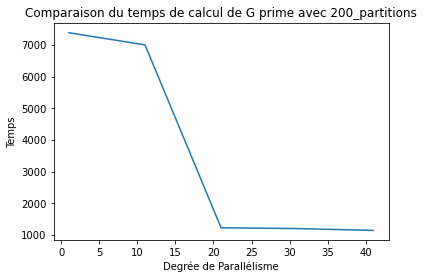

In [ ]:
plt.plot(degree_parallelisme, times_Gprime_moy_total)

plt.xlabel('Degrée de Parallélisme')
plt.ylabel('Temps')
plt.title('Comparaison du temps de calcul de G prime avec 200_partitions') 

plt.show()

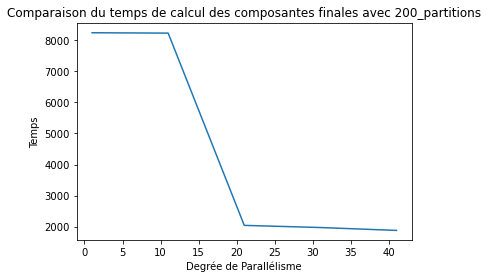

In [ ]:
plt.plot(degree_parallelisme, times_moy_total)

plt.xlabel('Degrée de Parallélisme')
plt.ylabel('Temps')
plt.title('Comparaison du temps de calcul des composantes finales avec 200_partitions') 

plt.show()

# Vérification des résultats : 

In [ ]:
spark = demarrer_spark(60)

shuffle 180
session démarrée, son id est  local-1713565470459


In [ ]:
# Création du graph avec igraph
from igraph import Graph

partition_folder = f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/200_partitions/"
df_with_components = calculate_partition_components(partition_folder,60)

df_exploded = df_with_components.select('file',  F.explode('components').alias('component'))
df_split = df_exploded.select("file", col("component.seqID").alias("seqID"), col("component.component_id").alias("component_id"))

# # Ajouter une colonne d'identifiant unique basée sur le couple (file, component_id)
windowSpec = Window.orderBy("file", "component_id")
df = df_split.withColumn("new_component_id", dense_rank().over(windowSpec))
new_df = df.select("seqID","new_component_id")


components_per_node = new_df \
    .groupby("seqID") \
    .agg(collect_set("new_component_id").alias("components")) \
    .withColumn("min_component", array_min("components"))


components_per_node_exploded = components_per_node.select('seqID', 'min_component', F.explode('components').alias('component'))
result = components_per_node_exploded.where(col("component") > col("min_component")).drop("seqID").dropDuplicates()


new_graph = result.withColumnRenamed("min_component", "src").withColumnRenamed("component", "dst")


new_graph.select('src', 'dst').write.csv('/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/200_part_graphe_G_prime.csv')

#--------------------
edges = spark.read.csv('/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/200_part_graphe_G_prime.csv', header=False, inferSchema=True)


# Conversion des arêtes DataFrame en liste de tuples
edges_list = edges.rdd.map(lambda row: (row[0], row[1])).collect()

#___________
composantes_df = components_2(edges_list)


In [ ]:
composantes_df_exploded = composantes_df \
        .groupby("component") \
        .agg(collect_set("partial_component").alias("partial_components")) \
        .withColumn("min_partial_component", array_min("partial_components")) \
        .selectExpr("explode(partial_components) as partial_component" , "min_partial_component")

# #resultat final en faisant une jointure gauche
result = components_per_node.join(composantes_df_exploded, components_per_node.min_component == composantes_df_exploded.partial_component, "left_outer") \
           .select(components_per_node.seqID, when(composantes_df_exploded.partial_component.isNull(), components_per_node.min_component).otherwise(composantes_df_exploded.min_partial_component).alias("new_component_id"))


#ecriture du résultat dans des fichier parquet
file_path = f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/composantes_finales"
result.repartition(1).write.mode("overwrite").parquet(file_path)

In [ ]:
import pandas as pd
comp_finales = pd.read_parquet("/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/composantes_finales/part-00000-b029e13d-fe4a-4a50-8637-053cae6409cd-c000.snappy.parquet")


In [ ]:
comp_finales.head(500)

,seqID,new_component_id
0,EukProt-v2_XP_001277102.1,163
1,EukProt-v2_XP_001277207.1,163
2,EukProt-v2_XP_001277400.1,163
3,EukProt-v2_XP_001277426.1,163
4,EukProt-v2_XP_001277442.1,163
...,...,...
495,METdb_00138-1-DN8667-c4-g1-i1.p1,906
496,METdb_00138-1-DN8667-c4-g1-i2.p1,906
497,METdb_00138-1-DN8667-c4-g1-i3.p1,906
498,METdb_00139-1-DN5009-c8-g1-i15.p1,906


In [ ]:
comp_finales['new_component_id'].nunique()

6987557

In [ ]:
comp_finales.shape

(25434662, 2)

### Verification du nombre de composantes calculé:

In [ ]:
# Chemin du dossier contenant les fichiers Parquet
folder_path = "/data/bd/dataset/proteine/80_80/G99/graph_with_components"

# Lire les fichiers Parquet
df = pd.read_parquet(folder_path)

# Afficher les premières lignes du DataFrame
print(df.head())

# Afficher le nombre de lignes et de colonnes dans le DataFrame
nb_rows, nb_cols = df.shape
print("Nombre de lignes dans le DataFrame :", nb_rows)
print("Nombre de colonnes dans le DataFrame :", nb_cols)

      query_id                     target_id  component_id  query_length  \
0  100001694:0                    99948071:3         35357            84   
1  100002413:0  EukProt-v2_GAXK01086771.1.p1       4198637           117   
2  100003668:0                    39074797:4           354           102   
3  100003668:0                    47972146:2           354           102   
4  100003668:0                    49586757:5           354           102   

   target_length  match_length  percent_identity       e_value  relative_sim  \
0             63            63             100.0  4.400000e-30         1.000   
1            903           117              99.1  2.500000e-58         0.991   
2            284           102              99.0  8.700000e-55         0.990   
3            259           102             100.0  1.700000e-55         1.000   
4            234           102              99.0  8.700000e-55         0.990   

   r  
0  1  
1  1  
2  1  
3  1  
4  1  
Nombre de lignes dan

In [ ]:
df['component_id'].nunique()

6987557